# 房屋价格预测项目

## 练习项目

在这个项目中，我还要注重练习新工具的使用：

- Pandas Profiling：自动生成数据集的概览
- Pandas Pipeline: 形成链式方法

In [1]:
import pandas as pd
import pdpipe as pdp

**Pandas Profiling 的使用方法：**
```
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.DataFrame(
    np.random.rand(100, 5),
    columns=['a', 'b', 'c', 'd', 'e']
)

profile = ProfileReport(df, title='Pandas Profiling Report')

Saving the report
If you want to generate a HTML report file, save the ProfileReport to an object and use the to_file() function:

profile.to_file('your_report.html')
Alternatively, you can obtain the data as JSON:

# As a string
json_data = profile.to_json()

# As a file
profile.to_file('your_report.json')
```

**对大数据集可以使用这样的方法：**
```
profile = ProfileReport(large_dataset, minimal=True)
profile.to_file('output.html')
```

**还可以直接在命令行中使用：**
pandas_profiling -h

**Pandas Pipeline 的使用方法:**
[这是一篇值得参考的博客](https://www.cnblogs.com/feffery/p/12179647.html)

```
# 以pdp.PdPipeline传入流程列表的方式创建pipeline
'''
pdp.ColDrop:删除列；
ApplyByCols：基于列做，应用apply
RowDrop：删除行
案例解释：
1、删除original_title列
2、对title列进行小写化处理
3、丢掉vote_average小于等于7，且original_language不为en的行
4、求得genres对应电影类型的数量保存为新列genres_num，并删除原有的genres列
5、丢掉genres_num小于等于5的行

这些操作操作直接使用pandas并不会花多少时间，但是如果想要不创造任何中间临时结果一步到位产生所需的数据框子集，
并且保持代码的可读性不是一件太容易的事，但是利用pdpipe，就可以非常优雅地实现上述过程
'''
first_pipeline = pdp.PdPipeline([pdp.ColDrop('original_title'), 
                                 pdp.ApplyByCols(columns=['title'], func=lambda x: x.lower()),
                                 pdp.RowDrop({'vote_average': lambda x: x <= 7, 'original_language': lambda x: x != 'en'}),
                                 pdp.ApplyByCols(columns=['genres'], func=lambda x: [item['name'] for item in eval(x)].__len__(), result_columns=['genres_num']),
                                 pdp.RowDrop({'genres_num': lambda x: x <= 5})])

# 将创建的pipeline直接作用于data直接得到所需结果，并打印流程信息
first_pipeline(data, verbose=True).reset_index(drop=True)
```

## 数据清洗

我们已经在命令行中使用了命令，生成对训练数据机的描述统计，如果没有生成过，可以使用如下命令：

接下来，我们对数据进行清洗，包含以下主要步骤：

<img src='../figs/data_clean.jpg' alt='数据清洗步骤' style='zoom:50%'>

### 选择子集：

此时，参考上一步生成的数据描述文档，和数据集的说明文档，对变量逐一进行检查，旨在理解哪些特征是有信息量的。

根据个人经验，房屋🏠价格影响程度由以下因素决定：

- 区位 (location)：周围环境、交通便利、坡度朝向、
- 户型 (size)：面积大小、庭院大小、规整程度、
- 设施 (facility)：水电、油气、加热、
- 产权 (property)：出售、长租、分配
- 材料 (material)：基本材料、装饰材料
- 评估 (evaluate)：新旧程度、状况评估

In [2]:
train = pd.read_csv('../data/train.csv')
train.head(3)

print("原始的变量:")
train.columns

print("原始训练数据集大小:")
train.shape

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


原始的变量:


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

原始训练数据集大小:


(1460, 81)

In [3]:
# 根据上述大致划分，对每个变量有一个归类

locations = {
    'MSSubClass': 'house_class_cat',  # 售卖类型，分类
    'MSZoning': 'house_zoning_cat',  # 区位，分类
    'LotFrontage': 'adj_street_frontage_num',  # 与街角相连的长度，数字
    'Street': 'street_cat',  # 街道是石子路还是铺砌的，分类
    'Alley': 'alley_cat',  # 门口小路是石子还是铺砌，分类
    'LandContour': 'land_flatness_cat',  # 土地的平坦类型
    'LandSlope': 'land_slope_cat',  # 土地的坡度
    'Neighborhood': 'neighborhood_cat',  # 街道类型
    'Condition1': 'location_condition_1_cat',  # 区位状况1
    'Condition2': 'location_condition_2_cat',  # 区位状况2
}

config = {
    'LotArea': 'area_num',  # 房屋面积
    'LotShape': 'shape_cat',  # 房屋形状
    'LotConfig': 'config_cat',  # 房屋结构
    'BldgType': 'dwelling_type_cat',  # 户型
    'HouseStyle': 'house_style_cat',  # 房屋风格
    'RoofStyle': 'roof_style_cat',  # 屋顶的风格
    'MasVnrArea': 'masonry_veneer_area_num',  # 隔板面积
    'BsmtFinSF1': 'basement_finish_1_num',  # 完工的基地面积
    'BsmtFinSF2': 'basement_finish_2_num',  # 完工的基地面积
    'BsmtUnfSF': 'unfinished_basement_num',  # 未完工的面积
    'TotalBsmtSF': 'total_basement_num',  # 总面积
    '1stFlrSF': '1st_floor_num',  # 一楼面积
    '2ndFlrSF': '2nd_floor_num',  # 二楼面积
    'LowQualFinSF': 'low_quality_finished_num',  # 低质量完工的面积
    'GrLivArea': 'living_area_num',  # 居住面积
    'BsmtFullBath': 'basement_full_bathroom_num',  # 高档浴室
    'BsmtHalfBath': 'basement_half_bathroom_num',  # 浴室
    'FullBath': 'full_bathroom_num',  # 总共的高档浴室
    'HalfBath': 'half_bathroom_num',  # 总共的浴室
    'BedroomAbvGr': 'bedroom_num',  # 卧室数量
    'KitchenAbvGr': 'kitchen_num',  # 厨房数量
    'TotRmsAbvGrd': 'total_rooms_num',  # 总共的房间数量
    'OpenPorchSF': 'open_porch_num',  # 开放门廊的面积
    'EnclosedPorch': 'enclose_proch_num',  # 关闭门廊的面积
    '3SsnPorch': 'season_porch_num',  # 能用三个季节的门廊（应该是冬季不能用？）
    'ScreenPorch': 'screen_porch_num',  # 屏风门廊
    
}

facilities = {
    'Utilities': 'utility_cat',  # 水、电、油、汽等是否有
    'Heating': 'heating_cat',  # 加热设施
    'CentralAir': 'center_air_bool',  # 有没有中央空调
    'Electrical': 'electrical_cat',  # 供电情况
    'Fireplaces': 'fireplaces_num',  # 总共的壁炉数量
    'GarageType': 'garage_type_cat',  # 车库情况
    'GarageYrBlt': 'garage_built_date',  # 车库修建年份
    'GarageFinish': 'garage_finish_cat',  # 车库装修状况
    'GarageArea': 'garage_area_num',  # 车库面积
    'PavedDrive': 'paved_drive_cat',  # 车库路是否铺砌
    'PoolArea': 'pool_area_num',  # 泳池面积
    'Fence': 'fence_cat',  # 围栏情况
    'MiscFeature': 'miscellaneous_cat',  # 没有提到的一些额外杂项设施
    'MiscVal': 'miscellaneous_price_num',  # 没有提到的额外杂项设施的价格
}

sales = {
    'YearBuilt': 'built_date',  # 修建时间
    'YearRemodAdd': 'remod_date',  # 装修时间
    'Functional': 'functional_condition_cat',  # 大部分房屋都是典型功能
    'MoSold': 'sold_month_str',  # 出售月份
    'YrSold': 'sold_year_str',  # 出售年份
    'SaleType': 'sale_type_cat',  # 交易类型
    'SaleCondition': 'sale_condition_cat',  # 交易条件
    'sold_time': 'sold_time',  # 交易日期
    'SalePrice': 'SalePrice',  # 交易金额，预测对象
}

materials = {
    'RoofMatl': 'roof_material_cat',  # 屋顶材料
    'Exterior1st': 'exterior_1st_cat',  # 外部第一层材料
    'Exterior2nd': 'exterior_2st_cat',  # 外部第二层材料
    'MasVnrType': 'masonry_veneer_type_cat',   # 隔板材料
    'WoodDeckSF': 'wood_deck_num',  # 木地板面积
    'Foundation': 'foundation_cat',  # 地基面积
}

evaluates = {
    'OverallQual': 'house_quality_cat', 
    'OverallCond': 'house_condition_cat', 
    'ExterQual': 'exterior_material_quality_cat',  # 外部材料的质量
    'ExterCond': 'exterior_material_condition_cat',  # 外部材料的状况
    'BsmtQual': 'basement_quality_cat',  # 基地质量
    'BsmtCond': 'basement_condition_cat',  # 基地状况
    'BsmtExposure': 'basement_exposure_cat',  # 基地采光
    'BsmtFinType1': 'basement_finish_type_1_cat',  # 基地完工类型评级
    'BsmtFinType2': 'basement_finish_type_2_cat',  # 基地完工评级
    'HeatingQC': 'heating_quality_condition_cat',  # 加热质量评级
    'KitchenQual': 'kitchen_quality_cat',  # 厨房质量
    'FireplaceQu': 'fireplace_quality_cat',  # 壁炉质量
    'GarageQual': 'garage_quality_cat',  # 车库质量
    'GarageCond': 'garage_condition_cat',  # 车库情况
    'PoolQC': 'pool_quality_cat',  # 泳池质量
}

variable_types = [locations, config, facilities, sales, materials, evaluates]

对上述变量进行子集选择，因为样本量远远大于特征数量，所以首先尽量保留所有特征。

唯一需要调整的，是把时间转为卖出之前的年份，然后删除原来不用的变量。

In [4]:
# 新增一个列, datetime 类型，是聚合了售出年份和月份的
agg_years_built = lambda row: row['YrSold'] - row['YearBuilt']
agg_years_remod = lambda row: row['YrSold'] - row['YearRemodAdd']

choose_subset = pdp.PdPipeline([
    pdp.ApplyToRows(agg_years_built, colname='built_years'),  # 新增出售年月
    pdp.ApplyToRows(agg_years_remod, colname='remod_years'),
    pdp.ColDrop(['YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd']),  # 删除原先的年月
])

train = choose_subset(train, verbose=True)

- Generating a column with a function .
- Generating a column with a function .
- Drop columns YrSold, MoSold, YearBuilt, YearRemodAdd


### 变量重命名

- 生成定序变量
- 生成哑变量
- 调整数据类型
- 使用上一步建立的些字典为变量重命名

In [5]:
# 生成定序变量，创建映射字典
level_dic = {
    # 用于大多数评估等级的变量
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    
    # 用于变量: BsmtFinType
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,

    # 用于变量: BsmtExposure
    'Av': 3,
    'Mn': 2,
    'No': 1,
}

# 创建 Pandas pipe
import numpy as np
clean_level_data = pdp.ApplyByCols(list(evaluates.keys()), lambda x: level_dic.get(x, np.nan))
clean_level_data(train, verbose=True).head(3)

- Apply a function  to columns OverallQual, OverallCond, ExterQual,
  ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1,
  BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual,
  GarageCond, PoolQC


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,SalePrice,built_years,remod_years
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,WD,Normal,208500,5,5
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,WD,Normal,181500,31,31
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,WD,Normal,223500,7,6


In [6]:
# 生成哑变量
datatypes = {k: [] for k in ['ordinal', 'category', 'numeric', 'datetime', 'bool']}

for dic in variable_types:
    for k, v in dic.items():
        if k not in train.columns:
            print("{} not in dataset, please check it!".format(k))
            continue
        if v.endswith('cat') and k in evaluates.keys():
            datatypes['ordinal'].append(k)
        elif v.endswith('cat'):
            datatypes['category'].append(k)
        elif v.endswith('num'):
            datatypes['numeric'].append(k)
        elif v.endswith('date') or v.endswith('time'):
            datatypes['datetime'].append(k)
        elif v.endswith('bool'):
            datatypes['bool'].append(k)

def update_datatypes(data, old_datatypes):
    dtypes = ['ordinal', 'category', 'numeric', 'datetime', 'bool']
    new_datatypes = {k: [] for k in dtypes}
    for k in datatypes:
        for item in old_datatypes[k]:
            if item in data:
                new_datatypes[k].append(item)
    return new_datatypes
            
            
# 创建 pipeline
clean_category_data = pdp.OneHotEncode(columns=datatypes['category'], drop_first=False, drop=True)
clean_category_data += pdp.OneHotEncode(columns=datatypes['bool'], drop=True)

YearBuilt not in dataset, please check it!
YearRemodAdd not in dataset, please check it!
MoSold not in dataset, please check it!
YrSold not in dataset, please check it!
sold_time not in dataset, please check it!


In [7]:
# 转换数据类型
transform_dtype = pdp.ApplyByCols(datatypes['numeric'], pd.to_numeric)
transform_dtype += pdp.ApplyByCols(datatypes['datetime'], pd.to_datetime)

# 重命名
rename_dict = {}
for dic in variable_types:
    rename_dict.update(dic)

# 重命名
rename_variable = pdp.PdPipeline([
    clean_category_data,
    clean_level_data,
    transform_dtype,
])

train = rename_variable(train, verbose=True)
train = pdp.ColRename({col: rename_dict.get(col, col) for col in train}).fit(train)

- One-hot encode MSSubClass, MSZoning, Street, Alley, LandContour,
  LandSlope, Neighborhood, Condition1, Condition2, LotShape, LotConfig,
  BldgType, HouseStyle, RoofStyle, Utilities, Heating, Electrical,
  GarageType, GarageFinish, PavedDrive, Fence, MiscFeature, Functional,
  SaleType, SaleCondition, RoofMatl, Exterior1st, Exterior2nd,
  MasVnrType, Foundation


Foundation: 100%|██████████| 30/30 [00:00<00:00, 527.42it/s]

- One-hot encode CentralAir



CentralAir: 100%|██████████| 1/1 [00:00<00:00, 427.73it/s]

- Apply a function  to columns OverallQual, OverallCond, ExterQual,
  ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1,
  BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual,
  GarageCond, PoolQC
- Apply a function  to columns LotFrontage, LotArea, MasVnrArea,
  BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF,
  LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath,
  HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, OpenPorchSF,
  EnclosedPorch, 3SsnPorch, ScreenPorch, Fireplaces, GarageArea,
  PoolArea, MiscVal, WoodDeckSF


- Apply a function  to columns GarageYrBlt


### 重复值和缺失值

观察数据报告，有四列大概是缺失值极多，必须要丢的。

有一列有效值大概在85%左右，可以后续研究中考虑是否加入。

没有重复值需要去除。

In [8]:
# 去掉太多缺失值的列
print("\nTop5 cols in missing values:\n")
train.isna().sum().sort_values(ascending=False).head()

print("\n去掉缺失值之前：")
train.shape

DROPNA_THRESH = 0.85  # 阈值选取 0.6
dropna_values = pdp.DropNa(axis=1, thresh=DROPNA_THRESH*len(train))
dropna_values += pdp.DropNa(axis=0, how='any')
train = dropna_values(train, verbose=True)

print("\n去掉缺失值超过{}之后：".format(DROPNA_THRESH))
train.shape

# # 填补缺失值

# print("Fill na-values by mean for numeric cols, mode for others.")
# train.fillna(train.mode(), inplace=True)


Top5 cols in missing values:



OverallQual    1460
OverallCond    1460
PoolQC         1453
FireplaceQu     690
LotFrontage     259
dtype: int64


去掉缺失值之前：


(1460, 254)

- Drops null values.
0 rows, 5 columns dropeed
- Drops null values.
121 rows, 0 columns dropeed

去掉缺失值超过0.85之后：


(1339, 249)

### 异常值处理

不知道零值太多的需不需要处理，初次先不弄。

一个异常值处理的流程案例：
```
pdp.RowDrop(conditions={'budget': lambda x: x <= 100000000,
                        'genres': lambda x: 'Action' not in x,
                        'release_date': lambda x: x == np.nan,
                        'vote_count': lambda x: x <= 1000},
           reduce='any').apply(data).shape[0]
```

In [9]:
print("清洗后的数据")
train.head()
train.shape
train.columns
'SalePrice' in train

清洗后的数据


,Id,LotArea,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,...,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_Y
0,1,8450,196.0,4,3,4.0,3.0,1.0,6.0,706,...,1,0,0,0,0,1,0,0,0,1
1,2,9600,0.0,3,3,4.0,3.0,4.0,5.0,978,...,0,1,0,0,1,0,0,0,0,1
2,3,11250,162.0,4,3,4.0,3.0,2.0,6.0,486,...,1,0,0,0,0,1,0,0,0,1
3,4,9550,0.0,3,3,3.0,4.0,1.0,5.0,216,...,0,1,0,1,0,0,0,0,0,1
4,5,14260,350.0,4,3,4.0,3.0,3.0,6.0,655,...,1,0,0,0,0,1,0,0,0,1


(1339, 249)

Index(['Id', 'LotArea', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       ...
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
       'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
       'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood',
       'CentralAir_Y'],
      dtype='object', length=249)

True

### 标准化

In [10]:
# 使用 sklearn：
# from sklearn import preprocessing
# preprocessing.scale()

def scale(array):
    a = array - array.mean()
    b = array.max() - array.min()
    return a/b

datatypes = update_datatypes(train, datatypes)
for col in datatypes['numeric']:
    print("Applied scale for variable {}.".format(col))
    train[col] = scale(train[col])

Applied scale for variable LotArea.
Applied scale for variable MasVnrArea.
Applied scale for variable BsmtFinSF1.
Applied scale for variable BsmtFinSF2.
Applied scale for variable BsmtUnfSF.
Applied scale for variable TotalBsmtSF.
Applied scale for variable 1stFlrSF.
Applied scale for variable 2ndFlrSF.
Applied scale for variable LowQualFinSF.
Applied scale for variable GrLivArea.
Applied scale for variable BsmtFullBath.
Applied scale for variable BsmtHalfBath.
Applied scale for variable FullBath.
Applied scale for variable HalfBath.
Applied scale for variable BedroomAbvGr.
Applied scale for variable KitchenAbvGr.
Applied scale for variable TotRmsAbvGrd.
Applied scale for variable OpenPorchSF.
Applied scale for variable EnclosedPorch.
Applied scale for variable 3SsnPorch.
Applied scale for variable ScreenPorch.
Applied scale for variable Fireplaces.
Applied scale for variable GarageArea.
Applied scale for variable PoolArea.
Applied scale for variable MiscVal.
Applied scale for variable

## 机器学习模型

首先使用多元线性回归 + CV 交叉验证，看看学习曲线，随着迭代数量增加是否增加学习效率

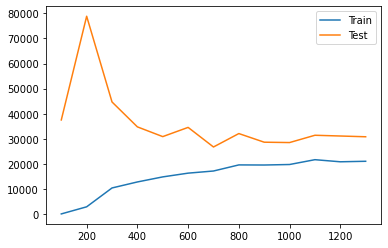

In [13]:
# 区分交叉验证和训练用
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = list(train.columns)
not_features = ['Id', 'SalePrice']
not_features.extend(list(datatypes['datetime']))

for i in not_features:
    features.remove(i)
predictor = ['SalePrice']

# 学习曲线
def get_min_rmse_prediction_in_cv(data):
    cv = KFold(shuffle=True, random_state=1)
    rmse_train, rmse_test = [], []
    for k, (train_index, test_index) in enumerate(cv.split(data)):
        X_train, y_train = train[features].iloc[train_index, :], train[predictor].iloc[train_index]
        X_test, y_test = train[features].iloc[test_index], train[predictor].iloc[test_index]
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        train_prediction = lr.predict(X_train)
        test_prediction = lr.predict(X_test)
        rmse_train.append(np.sqrt(mean_squared_error(y_train, train_prediction)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, test_prediction)))
    return min(rmse_train), min(rmse_test)


rmse_trains, rmse_tests = [], []
samples_len = list(range(100, len(train), 100))
for i in samples_len:
    rmse_train, rmse_test = get_min_rmse_prediction_in_cv(train.iloc[:i])
    rmse_tests.append(rmse_test)
    rmse_trains.append(rmse_train)

from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(samples_len, rmse_trains, label='Train')
plt.plot(samples_len, rmse_tests, label='Test')
plt.legend()
plt.xlabel("Size of dataset")
plt.ylabel("RMSE")
plt.show();